# LSTM for Packet MQTT for Multiclass Classification

I have kept the final code in the begining. If you want to also look into dataset creation, data cleaning and other experiments then you can find that in Appendix Section

#### In this I have created an LSTM model and trained to make multiclass prediction. I have considered timestamp as well. I convert the timestamp into the range

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.layers import Embedding, concatenate, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv('mqtt_merged_timeframe_multiclass_cleaned.csv')

# Drop the unnamed column
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

df = df.drop(['src_ip', 'dst_ip','src_port','ip_len','mqtt_messagelength'],axis=1)

int_columns = df.select_dtypes(include=['int64']).columns
df[int_columns] = df[int_columns].astype('float32')

# Convert all float64 columns to float32
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].astype('float32')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
# Drop the rows that contain invalid datetime values
df.dropna(subset=['timestamp'], inplace=True)


numerical_columns = list(df.select_dtypes(include=['int32', 'float32']).columns)
numerical_columns.remove('is_attack')
print(numerical_columns)


# Identify categorical columns
categorical_columns = list(df.select_dtypes(include=['object', 'bool']).columns)
print(categorical_columns)

# Identify time-based columns
time_columns = list(df.select_dtypes(include=['datetime64']).columns)
print(time_columns)

# Preprocess data
num_features = numerical_columns
cat_features = categorical_columns
time_features = time_columns
target = 'is_attack'

# Preprocess numerical features
X_num = df[num_features].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Preprocess categorical features
X_cat = df[cat_features].values
encoder = OneHotEncoder()
X_cat = encoder.fit_transform(X_cat).toarray()

# Preprocess time features
X_time = df[time_features].values
# convert timestamps to seconds since epoch
#X_time = np.array([pd.to_datetime(x).timestamp() for x in X_time])
X_time = df[time_features].values.astype('datetime64[s]').astype('int64')
# normalize timestamps to range [0, 1]
X_time = (X_time - X_time.min()) / (X_time.max() - X_time.min())

# Combine preprocessed features
X = np.concatenate((X_num, X_cat, X_time.reshape(-1, 1)), axis=1)
y = df[target].values

y = to_categorical(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#applying SMOTE for balancing
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[Precision(), Recall()])

# Compile the model

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=[Precision(), Recall()])
# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

['ttl', 'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'dst_port', 'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn', 'tcp_flag_fin', 'mqtt_messagetype', 'mqtt_flag_uname', 'mqtt_flag_passwd', 'mqtt_flag_retain', 'mqtt_flag_qos', 'mqtt_flag_willflag', 'mqtt_flag_clean', 'mqtt_flag_reserved']
['protocol']
['timestamp']
Epoch 1/5
3735/3735 [==============================] - 56s 14ms/step - loss: 0.4179 - precision: 0.9909 - recall: 0.7573 - val_loss: 0.1061 - val_precision: 0.9526 - val_recall: 0.9518
Epoch 2/5
3735/3735 [==============================] - 50s 13ms/step - loss: 0.0615 - precision: 0.9940 - recall: 0.9938 - val_loss: 0.0220 - val_precision: 0.9977 - val_recall: 0.9974
Epoch 3/5
3735/3735 [==============================] - 51s 14ms/step - loss: 0.0207 - precision: 0.9978 - recall: 0.9978 - val_loss: 0.0139 - val_precision: 0.9960 - val_recall: 0.9960
Epoch 4/5
3735/3735 [==============

In [4]:
y_test_arr = np.argmax(y_test,axis=1)

In [5]:
### Function to create confusion matrix ###
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
output_test = model.predict(X_test)
y_pred = np.argmax(output_test,  axis=1)

In [7]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_arr, y_pred)
print('Accuracy: ', accuracy)

Accuracy:  1.0


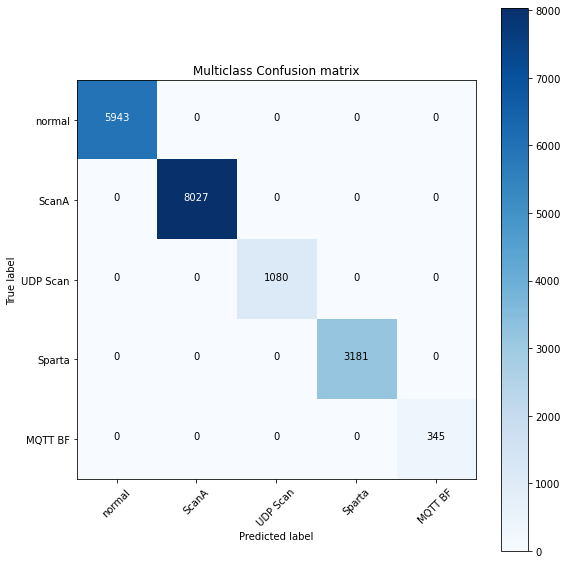

In [8]:
cnf_matrix = confusion_matrix(y_test_arr, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['normal','ScanA','UDP Scan','Sparta','MQTT BF'],
                      title='Multiclass Confusion matrix')
plt.show()

In [9]:
# Get predicted labels for the test set
y_pred = model.predict(X_test)

# Compute other metrics such as precision, recall, F1-score, etc.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5943
           1       1.00      1.00      1.00      8027
           2       1.00      1.00      1.00      1080
           3       1.00      1.00      1.00      3181
           4       1.00      1.00      1.00       345

   micro avg       1.00      1.00      1.00     18576
   macro avg       1.00      1.00      1.00     18576
weighted avg       1.00      1.00      1.00     18576
 samples avg       1.00      1.00      1.00     18576



In [10]:
history.history

{'loss': [0.4179486632347107,
  0.06148681417107582,
  0.02066446654498577,
  0.009592816233634949,
  0.007576109375804663],
 'precision': [0.990932285785675,
  0.9940317273139954,
  0.9977905750274658,
  0.9991044998168945,
  0.9988869428634644],
 'recall': [0.7572600245475769,
  0.993823766708374,
  0.9977822303771973,
  0.9991044998168945,
  0.998878538608551],
 'val_loss': [0.10609409958124161,
  0.02195742353796959,
  0.013905210420489311,
  0.007703989744186401,
  0.0017924424028024077],
 'val_precision': [0.9525862336158752,
  0.9976845383644104,
  0.9960163831710815,
  1.0,
  1.0],
 'val_recall': [0.9517657160758972,
  0.9974160194396973,
  0.9960163831710815,
  1.0,
  1.0]}

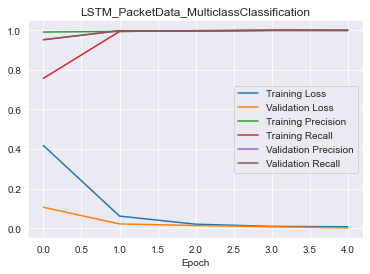

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

epochs = range(0,5)
sns.set_style('darkgrid')
sns.lineplot(x=epochs, y=history.history['loss'], label='Training Loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], label='Validation Loss')
sns.lineplot(x=epochs, y=history.history['precision'], label='Training Precision')
sns.lineplot(x=epochs, y=history.history['recall'], label='Training Recall')
sns.lineplot(x=epochs, y=history.history['val_precision'], label='Validation Precision')
sns.lineplot(x=epochs, y=history.history['val_recall'], label='Validation Recall')

plt.title('LSTM_PacketData_MulticlassClassification')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
import tensorflow as tf
import pydot
import graphviz

tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [21]:
!pip install pydot


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
!pip install graphviz

     -------------------------------------- 47.0/47.0 kB 782.9 kB/s eta 0:00:00



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


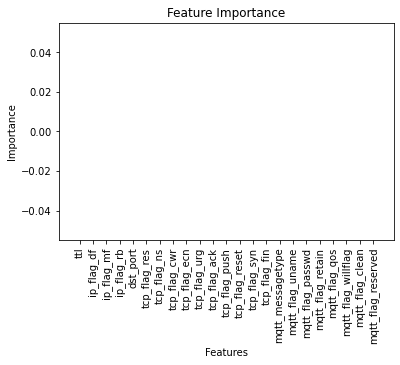

In [4]:
# import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('mqtt_merged_timeframe_multiclass_cleaned.csv')
# Drop the unnamed column
data = data.drop(data.columns[data.columns.str.contains('unnamed', case=False)], axis=1)
data = data[data['timestamp'] != 'timestamp']
data = data.drop(['timestamp', 'src_ip','src_port', 'dst_ip', 'protocol','ip_len','mqtt_messagelength'], axis=1)

X = data.drop(['is_attack'],axis=1)
# separate target variable from features
y = data['is_attack']


# initialize model
rfc = RandomForestClassifier()

# train model
rfc.fit(X, y)

# calculate feature importances
importances = rfc.feature_importances_

# create bar chart of feature importances
plt.bar(X.columns, importances)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# ---------------------------------------------------------------------------------------
# Appendix

In [30]:
data = pd.read_csv('mqtt_merged_timeframe_multiclass_cleaned.csv')
dfata = data[data['timestamp'] != 'timestamp']
data = data.drop(['timestamp', 'src_ip', 'dst_ip', 'protocol'], axis=1)

In [27]:
X

array([[ 0.  ,  0.82,  0.  , ...,  0.  ,  1.  ,  0.71],
       [ 0.  , -1.22,  0.  , ...,  0.  ,  1.  ,  0.55],
       [ 0.  , -1.1 ,  0.  , ...,  0.  ,  1.  ,  0.55],
       ...,
       [ 0.  ,  0.94,  0.  , ...,  0.  ,  1.  ,  0.08],
       [ 0.  ,  0.94,  0.  , ...,  0.  ,  1.  ,  0.09],
       [ 0.  , -1.1 ,  0.  , ...,  0.  ,  1.  ,  0.55]])

In [12]:
X_num

,ttl,ip_len,ip_flag_df,ip_flag_mf,ip_flag_rb,src_port,dst_port,tcp_flag_res,tcp_flag_ns,tcp_flag_cwr,...,mqtt_messagetype,mqtt_messagelength,mqtt_flag_uname,mqtt_flag_passwd,mqtt_flag_retain,mqtt_flag_qos,mqtt_flag_willflag,mqtt_flag_clean,mqtt_flag_reserved,is_attack
0,64.0,101.0,1.0,0.0,0.0,40546.0,1883.0,0.0,0.0,0.0,...,1.0,47.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
1,64.0,83.0,1.0,0.0,0.0,45213.0,1883.0,0.0,0.0,0.0,...,1.0,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,64.0,84.0,1.0,0.0,0.0,57301.0,1883.0,0.0,0.0,0.0,...,1.0,30.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,64.0,102.0,1.0,0.0,0.0,34626.0,1883.0,0.0,0.0,0.0,...,1.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
4,64.0,101.0,1.0,0.0,0.0,44002.0,1883.0,0.0,0.0,0.0,...,1.0,47.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92874,64.0,87.0,1.0,0.0,0.0,52597.0,1883.0,0.0,0.0,0.0,...,1.0,33.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
92875,64.0,83.0,1.0,0.0,0.0,48221.0,1883.0,0.0,0.0,0.0,...,1.0,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
92876,64.0,102.0,1.0,0.0,0.0,44504.0,1883.0,0.0,0.0,0.0,...,1.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
92877,64.0,102.0,1.0,0.0,0.0,35122.0,1883.0,0.0,0.0,0.0,...,1.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.layers import Embedding, concatenate, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
col_names = ['timestamp', 'src_ip', 'dst_ip', 'protocol', 'ttl', 'ip_len', 'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port', 'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn', 'tcp_flag_fin', 'mqtt_messagetype',
'mqtt_messagelength', 'mqtt_flag_uname', 'mqtt_flag_passwd', 'mqtt_flag_retain', 'mqtt_flag_qos', 'mqtt_flag_willflag', 'mqtt_flag_clean', 'mqtt_flag_reserved', 'is_attack']


In [4]:
df1 = pd.read_csv('packet_features\\normal.csv', header=None, names = col_names, nrows=400000)
#df1 = df1[df1['timestamp'] != 'timestamp']
#df1 = df1.drop(['timestamp', 'src_ip', 'dst_ip', 'protocol'], axis=1)
#df1 = df1.astype('float32')
df1['is_attack']=[0 for i in range(len(df1))]
print(df1.isna().any())
df1=df1.dropna()
print(df1.values.shape)
print(df1.describe()) 
print(len(df1))
print(df1.is_attack.unique())
    
df2 = pd.read_csv('packet_features\\scan_A.csv', header=None, names = col_names, nrows=400000)
#df2 = df2[df2['timestamp'] != 'timestamp']
#df2 = df2.drop(['timestamp', 'src_ip', 'dst_ip', 'protocol'], axis=1)
#df2 = df2.astype('float32')
df2['is_attack']=[2 for i in range(len(df2))]
print(df2.isna().any())
df2=df2.dropna()
print(df2.values.shape)
print(df2.describe()) 
print(len(df2))
print(df2.is_attack.unique())

df3 = pd.read_csv('packet_features\\scan_sU.csv', header=None, names = col_names, nrows=400000)
#df3 = df3[df3['timestamp'] != 'timestamp']
#df3 = df3.drop(['timestamp', 'src_ip', 'dst_ip', 'protocol'], axis=1)
#df3 = df3.astype('float32')
df3['is_attack']=[3 for i in range(len(df3))]
print(df3.isna().any())
df3=df3.dropna()
print(df3.values.shape)
print(df3.describe()) 
print(len(df3))
print(df3.is_attack.unique())

df4 = pd.read_csv('packet_features\\sparta.csv', header=None, names = col_names, nrows=400000)
#df4 = df4[df4['timestamp'] != 'timestamp']
#df4 = df4.drop(['timestamp', 'src_ip', 'dst_ip', 'protocol'], axis=1)
#df4 = df4.astype('float32')
df4['is_attack']=[4 for i in range(len(df4))]
print(df4.isna().any())
df4=df4.dropna()
print(df4.values.shape)
print(df4.describe()) 
print(len(df4))
print(df4.is_attack.unique())

df5 = pd.read_csv('packet_features\\mqtt_bruteforce.csv', header=None, names = col_names, nrows=400000)
#df5 = df5[df5['timestamp'] != 'timestamp']
#df5 = df5.drop(['timestamp', 'src_ip', 'dst_ip', 'protocol'], axis=1)
#df5 = df5.astype('float32')
df5['is_attack']=[1 for i in range(len(df5))]
print(df5.isna().any())
df5=df5.dropna()
print(df5.values.shape)
print(df5.describe()) 
print(len(df5))
print(df5.is_attack.unique())
   
df = pd.concat ([df1, df2, df3, df4,df5]).sample(frac=1)
print(df.head())
print(df.is_attack.value_counts())
df.to_csv('mqtt_merged_timeframe_multiclass.csv')

C:\Users\abhi0\AppData\Local\Temp\ipykernel_16560\979778231.py:1: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('packet_features\\normal.csv', header=None, names = col_names, nrows=400000)


timestamp             False
src_ip                 True
dst_ip                 True
protocol              False
ttl                    True
ip_len                 True
ip_flag_df             True
ip_flag_mf             True
ip_flag_rb             True
src_port              False
dst_port              False
tcp_flag_res           True
tcp_flag_ns            True
tcp_flag_cwr           True
tcp_flag_ecn           True
tcp_flag_urg           True
tcp_flag_ack           True
tcp_flag_push          True
tcp_flag_reset         True
tcp_flag_syn           True
tcp_flag_fin           True
mqtt_messagetype       True
mqtt_messagelength     True
mqtt_flag_uname        True
mqtt_flag_passwd       True
mqtt_flag_retain       True
mqtt_flag_qos          True
mqtt_flag_willflag     True
mqtt_flag_clean        True
mqtt_flag_reserved     True
is_attack             False
dtype: bool
(30210, 31)
       is_attack
count    30210.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%   

C:\Users\abhi0\AppData\Local\Temp\ipykernel_16560\979778231.py:13: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('packet_features\\scan_A.csv', header=None, names = col_names, nrows=400000)


timestamp             False
src_ip                 True
dst_ip                 True
protocol              False
ttl                    True
ip_len                 True
ip_flag_df             True
ip_flag_mf             True
ip_flag_rb             True
src_port              False
dst_port              False
tcp_flag_res           True
tcp_flag_ns            True
tcp_flag_cwr           True
tcp_flag_ecn           True
tcp_flag_urg           True
tcp_flag_ack           True
tcp_flag_push          True
tcp_flag_reset         True
tcp_flag_syn           True
tcp_flag_fin           True
mqtt_messagetype       True
mqtt_messagelength     True
mqtt_flag_uname        True
mqtt_flag_passwd       True
mqtt_flag_retain       True
mqtt_flag_qos          True
mqtt_flag_willflag     True
mqtt_flag_clean        True
mqtt_flag_reserved     True
is_attack             False
dtype: bool
(5336, 31)
       is_attack
count     5336.0
mean         2.0
std          0.0
min          2.0
25%          2.0
50%    

C:\Users\abhi0\AppData\Local\Temp\ipykernel_16560\979778231.py:25: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('packet_features\\scan_sU.csv', header=None, names = col_names, nrows=400000)


timestamp             False
src_ip                 True
dst_ip                 True
protocol              False
ttl                    True
ip_len                 True
ip_flag_df             True
ip_flag_mf             True
ip_flag_rb             True
src_port              False
dst_port              False
tcp_flag_res           True
tcp_flag_ns            True
tcp_flag_cwr           True
tcp_flag_ecn           True
tcp_flag_urg           True
tcp_flag_ack           True
tcp_flag_push          True
tcp_flag_reset         True
tcp_flag_syn           True
tcp_flag_fin           True
mqtt_messagetype       True
mqtt_messagelength     True
mqtt_flag_uname        True
mqtt_flag_passwd       True
mqtt_flag_retain       True
mqtt_flag_qos          True
mqtt_flag_willflag     True
mqtt_flag_clean        True
mqtt_flag_reserved     True
is_attack             False
dtype: bool
(15922, 31)
       is_attack
count    15922.0
mean         3.0
std          0.0
min          3.0
25%          3.0
50%   

C:\Users\abhi0\AppData\Local\Temp\ipykernel_16560\979778231.py:37: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('packet_features\\sparta.csv', header=None, names = col_names, nrows=400000)


timestamp             False
src_ip                False
dst_ip                False
protocol              False
ttl                   False
ip_len                False
ip_flag_df            False
ip_flag_mf            False
ip_flag_rb            False
src_port              False
dst_port              False
tcp_flag_res           True
tcp_flag_ns            True
tcp_flag_cwr           True
tcp_flag_ecn           True
tcp_flag_urg           True
tcp_flag_ack           True
tcp_flag_push          True
tcp_flag_reset         True
tcp_flag_syn           True
tcp_flag_fin           True
mqtt_messagetype       True
mqtt_messagelength     True
mqtt_flag_uname        True
mqtt_flag_passwd       True
mqtt_flag_retain       True
mqtt_flag_qos          True
mqtt_flag_willflag     True
mqtt_flag_clean        True
mqtt_flag_reserved     True
is_attack             False
dtype: bool
(1549, 31)
       is_attack
count     1549.0
mean         4.0
std          0.0
min          4.0
25%          4.0
50%    

C:\Users\abhi0\AppData\Local\Temp\ipykernel_16560\979778231.py:49: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df5 = pd.read_csv('packet_features\\mqtt_bruteforce.csv', header=None, names = col_names, nrows=400000)


timestamp             False
src_ip                False
dst_ip                False
protocol              False
ttl                   False
ip_len                False
ip_flag_df            False
ip_flag_mf            False
ip_flag_rb            False
src_port              False
dst_port              False
tcp_flag_res           True
tcp_flag_ns            True
tcp_flag_cwr           True
tcp_flag_ecn           True
tcp_flag_urg           True
tcp_flag_ack           True
tcp_flag_push          True
tcp_flag_reset         True
tcp_flag_syn           True
tcp_flag_fin           True
mqtt_messagetype       True
mqtt_messagelength     True
mqtt_flag_uname        True
mqtt_flag_passwd       True
mqtt_flag_retain       True
mqtt_flag_qos          True
mqtt_flag_willflag     True
mqtt_flag_clean        True
mqtt_flag_reserved     True
is_attack             False
dtype: bool
(39867, 31)
       is_attack
count    39867.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%   

In [18]:
df5.head()

,timestamp,src_ip,dst_ip,protocol,ttl,ip_len,ip_flag_df,ip_flag_mf,ip_flag_rb,src_port,...,mqtt_messagetype,mqtt_messagelength,mqtt_flag_uname,mqtt_flag_passwd,mqtt_flag_retain,mqtt_flag_qos,mqtt_flag_willflag,mqtt_flag_clean,mqtt_flag_reserved,is_attack
0,timestamp,src_ip,dst_ip,protocol,ttl,ip_len,ip_flag_df,ip_flag_mf,ip_flag_rb,src_port,...,mqtt_messagetype,mqtt_messagelength,mqtt_flag_uname,mqtt_flag_passwd,mqtt_flag_retain,mqtt_flag_qos,mqtt_flag_willflag,mqtt_flag_clean,mqtt_flag_reserved,1
156,"02/14/2020, 13:45:34:726067",192.168.2.5,192.168.1.7,MQTT,64,82,1,0,0,43975,...,1,28,1,1,0,0,0,1,0,1
166,"02/14/2020, 13:45:34:729526",192.168.2.5,192.168.1.7,MQTT,64,81,1,0,0,35235,...,1,27,1,1,0,0,0,1,0,1
177,"02/14/2020, 13:45:34:731645",192.168.2.5,192.168.1.7,MQTT,64,85,1,0,0,57521,...,1,31,1,1,0,0,0,1,0,1
187,"02/14/2020, 13:45:34:735649",192.168.2.5,192.168.1.7,MQTT,64,84,1,0,0,57097,...,1,30,1,1,0,0,0,1,0,1


In [7]:
df = pd.read_csv('mqtt_merged_timeframe.csv')

C:\Users\abhi0\AppData\Local\Temp\ipykernel_6816\1987217101.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('mqtt_merged_timeframe.csv')


Unnamed: 0             int64
timestamp             object
src_ip                object
dst_ip                object
protocol              object
ttl                   object
ip_len                object
ip_flag_df            object
ip_flag_mf            object
ip_flag_rb            object
src_port              object
dst_port              object
tcp_flag_res          object
tcp_flag_ns           object
tcp_flag_cwr          object
tcp_flag_ecn          object
tcp_flag_urg          object
tcp_flag_ack          object
tcp_flag_push         object
tcp_flag_reset        object
tcp_flag_syn          object
tcp_flag_fin          object
mqtt_messagetype      object
mqtt_messagelength    object
mqtt_flag_uname       object
mqtt_flag_passwd      object
mqtt_flag_retain      object
mqtt_flag_qos         object
mqtt_flag_willflag    object
mqtt_flag_clean       object
mqtt_flag_reserved    object
is_attack              int64
dtype: object

In [5]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%Y, %H:%M:%S:%f', errors='coerce')

# Drop the rows that contain invalid datetime values
df.dropna(subset=['timestamp'], inplace=True)

# Check the updated DataFrame
print(df.head())

                        timestamp       src_ip       dst_ip protocol ttl  \
154267 2020-02-14 14:51:40.738899    10.0.0.17  192.168.1.7     MQTT  64   
3612   2020-02-14 13:45:35.197743  192.168.2.5  192.168.1.7     MQTT  64   
99767  2020-02-14 13:45:47.297960  192.168.2.5  192.168.1.7     MQTT  64   
222732 2020-02-14 14:58:28.712255     10.0.0.5  192.168.1.7     MQTT  64   
335247 2020-02-14 10:44:45.248734    10.0.0.12  192.168.1.7     MQTT  64   

       ip_len ip_flag_df ip_flag_mf ip_flag_rb src_port  ... mqtt_messagetype  \
154267    101          1          0          0    40546  ...              1.0   
3612       83          1          0          0    45213  ...                1   
99767      84          1          0          0    57301  ...              1.0   
222732    102          1          0          0    34626  ...              1.0   
335247    101          1          0          0    44002  ...              1.0   

       mqtt_messagelength mqtt_flag_uname mqtt_flag_pass

In [6]:
exclude_cols = ['timestamp', 'src_ip', 'dst_ip', 'protocol']
col_names = df.columns
numeric_cols = col_names.difference(exclude_cols)

# Convert the numeric columns to float
df[numeric_cols] = df[numeric_cols].astype('float32')

In [7]:
# Drop the unnamed column
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

# Check the updated DataFrame
print(df.head())

                        timestamp       src_ip       dst_ip protocol   ttl  \
154267 2020-02-14 14:51:40.738899    10.0.0.17  192.168.1.7     MQTT  64.0   
3612   2020-02-14 13:45:35.197743  192.168.2.5  192.168.1.7     MQTT  64.0   
99767  2020-02-14 13:45:47.297960  192.168.2.5  192.168.1.7     MQTT  64.0   
222732 2020-02-14 14:58:28.712255     10.0.0.5  192.168.1.7     MQTT  64.0   
335247 2020-02-14 10:44:45.248734    10.0.0.12  192.168.1.7     MQTT  64.0   

        ip_len  ip_flag_df  ip_flag_mf  ip_flag_rb  src_port  ...  \
154267   101.0         1.0         0.0         0.0   40546.0  ...   
3612      83.0         1.0         0.0         0.0   45213.0  ...   
99767     84.0         1.0         0.0         0.0   57301.0  ...   
222732   102.0         1.0         0.0         0.0   34626.0  ...   
335247   101.0         1.0         0.0         0.0   44002.0  ...   

        mqtt_messagetype  mqtt_messagelength  mqtt_flag_uname  \
154267               1.0                47.0       

In [8]:
df

,timestamp,src_ip,dst_ip,protocol,ttl,ip_len,ip_flag_df,ip_flag_mf,ip_flag_rb,src_port,...,mqtt_messagetype,mqtt_messagelength,mqtt_flag_uname,mqtt_flag_passwd,mqtt_flag_retain,mqtt_flag_qos,mqtt_flag_willflag,mqtt_flag_clean,mqtt_flag_reserved,is_attack
154267,2020-02-14 14:51:40.738899,10.0.0.17,192.168.1.7,MQTT,64.0,101.0,1.0,0.0,0.0,40546.0,...,1.0,47.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
3612,2020-02-14 13:45:35.197743,192.168.2.5,192.168.1.7,MQTT,64.0,83.0,1.0,0.0,0.0,45213.0,...,1.0,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
99767,2020-02-14 13:45:47.297960,192.168.2.5,192.168.1.7,MQTT,64.0,84.0,1.0,0.0,0.0,57301.0,...,1.0,30.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
222732,2020-02-14 14:58:28.712255,10.0.0.5,192.168.1.7,MQTT,64.0,102.0,1.0,0.0,0.0,34626.0,...,1.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,3.0
335247,2020-02-14 10:44:45.248734,10.0.0.12,192.168.1.7,MQTT,64.0,101.0,1.0,0.0,0.0,44002.0,...,1.0,47.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195051,2020-02-14 13:45:59.197689,192.168.2.5,192.168.1.7,MQTT,64.0,87.0,1.0,0.0,0.0,52597.0,...,1.0,33.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
175187,2020-02-14 13:45:56.705709,192.168.2.5,192.168.1.7,MQTT,64.0,83.0,1.0,0.0,0.0,48221.0,...,1.0,29.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
298069,2020-02-14 10:40:49.329417,10.0.0.10,192.168.1.7,MQTT,64.0,102.0,1.0,0.0,0.0,44504.0,...,1.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
349201,2020-02-14 10:46:11.691874,10.0.0.16,192.168.1.7,MQTT,64.0,102.0,1.0,0.0,0.0,35122.0,...,1.0,48.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [9]:
df.to_csv('mqtt_merged_timeframe_multiclass_cleaned.csv')

In [41]:
# Display the data types of each column
print(df.dtypes)

# Identify numerical columns
numerical_columns = list(df.select_dtypes(include=['int32', 'float32']).columns)
print(numerical_columns)

# Identify categorical columns
categorical_columns = list(df.select_dtypes(include=['object', 'bool']).columns)
print(categorical_columns)

# Identify time-based columns
time_columns = list(df.select_dtypes(include=['datetime64']).columns)
print(time_columns)

timestamp             datetime64[ns]
src_ip                        object
dst_ip                        object
protocol                      object
ttl                          float32
ip_len                       float32
ip_flag_df                   float32
ip_flag_mf                   float32
ip_flag_rb                   float32
src_port                     float32
dst_port                     float32
tcp_flag_res                 float32
tcp_flag_ns                  float32
tcp_flag_cwr                 float32
tcp_flag_ecn                 float32
tcp_flag_urg                 float32
tcp_flag_ack                 float32
tcp_flag_push                float32
tcp_flag_reset               float32
tcp_flag_syn                 float32
tcp_flag_fin                 float32
mqtt_messagetype             float32
mqtt_messagelength           float32
mqtt_flag_uname              float32
mqtt_flag_passwd             float32
mqtt_flag_retain             float32
mqtt_flag_qos                float32
m

In [10]:
df = pd.read_csv('mqtt_merged_timeframe_multiclass_cleaned.csv')
df.dtypes


Unnamed: 0              int64
timestamp              object
src_ip                 object
dst_ip                 object
protocol               object
ttl                   float64
ip_len                float64
ip_flag_df            float64
ip_flag_mf            float64
ip_flag_rb            float64
src_port              float64
dst_port              float64
tcp_flag_res          float64
tcp_flag_ns           float64
tcp_flag_cwr          float64
tcp_flag_ecn          float64
tcp_flag_urg          float64
tcp_flag_ack          float64
tcp_flag_push         float64
tcp_flag_reset        float64
tcp_flag_syn          float64
tcp_flag_fin          float64
mqtt_messagetype      float64
mqtt_messagelength    float64
mqtt_flag_uname       float64
mqtt_flag_passwd      float64
mqtt_flag_retain      float64
mqtt_flag_qos         float64
mqtt_flag_willflag    float64
mqtt_flag_clean       float64
mqtt_flag_reserved    float64
is_attack             float64
dtype: object

In [3]:
    import pandas as pd
    import numpy as np
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
    from tensorflow.keras.layers import Embedding, concatenate, Flatten
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder

    # Load dataset
    df = pd.read_csv('mqtt_merged_timeframe_cleaned.csv')

    # Drop the unnamed column
    df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

    int_columns = df.select_dtypes(include=['int64']).columns
    df[int_columns] = df[int_columns].astype('float32')

    # Convert all float64 columns to float32
    float_columns = df.select_dtypes(include=['float64']).columns
    df[float_columns] = df[float_columns].astype('float32')


    # Check the updated DataFrame
    print(df.head())

    numerical_columns = list(df.select_dtypes(include=['int32', 'float32']).columns)
    print(numerical_columns)

    # Identify categorical columns
    categorical_columns = list(df.select_dtypes(include=['object', 'bool']).columns)
    print(categorical_columns)

    # Identify time-based columns
    time_columns = list(df.select_dtypes(include=['datetime64']).columns)
    print(time_columns)

    # Preprocess data
    num_features = numerical_columns
    cat_features = categorical_columns
    time_features = time_columns
    target = 'is_attack'

    # Preprocess numerical features
    X_num = df[num_features].values
    scaler = StandardScaler()
    X_num = scaler.fit_transform(X_num)

    # Preprocess categorical features
    X_cat = df[cat_features].values
    encoder = OneHotEncoder()
    X_cat = encoder.fit_transform(X_cat).toarray()

    # Preprocess time features
    X_time = df[time_features].values
    # convert timestamps to seconds since epoch
    X_time = np.array([pd.Timestamp(x).timestamp() for x in X_time])
    # normalize timestamps to range [0, 1]
    X_time = (X_time - X_time.min()) / (X_time.max() - X_time.min())

    # Combine preprocessed features
    X = np.concatenate((X_num, X_cat, X_time.reshape(-1, 1)), axis=1)
    y = df[target].values

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build LSTM model
    input_num = Input(shape=(X_num.shape[1],))
    input_cat = Input(shape=(X_cat.shape[1],))
    input_time = Input(shape=(1,))
    embedding_layer = Embedding(input_dim=X_cat.shape[1], output_dim=32)(input_cat)
    flatten_layer = Flatten()(embedding_layer)
    concat_layer = concatenate([input_num, flatten_layer, input_time])
    lstm_layer = LSTM(units=64, return_sequences=True)(concat_layer)
    dropout_layer = Dropout(0.2)(lstm_layer)
    lstm_layer2 = LSTM(units=32)(dropout_layer)
    dropout_layer2 = Dropout(0.2)(lstm_layer2)
    output_layer = Dense(units=1, activation='sigmoid')(dropout_layer2)
    model = tf.keras.Model(inputs=[input_num, input_cat, input_time], outputs=output_layer)


                    timestamp       src_ip       dst_ip protocol   ttl  \
0  2020-02-14 16:45:36.818127     10.0.0.5  192.168.1.7     MQTT  64.0   
1  2020-02-14 13:46:07.536602  192.168.2.5  192.168.1.7     MQTT  64.0   
2  2020-02-14 14:26:10.570122    10.0.0.13  192.168.1.7     MQTT  64.0   
3  2020-02-14 10:35:43.709653     10.0.0.8  192.168.1.7     MQTT  64.0   
4  2020-02-14 10:42:01.411879    10.0.0.12  192.168.1.7     MQTT  64.0   

   ip_len  ip_flag_df  ip_flag_mf  ip_flag_rb  src_port  ...  \
0   102.0         1.0         0.0         0.0   47394.0  ...   
1    85.0         1.0         0.0         0.0   54493.0  ...   
2   101.0         1.0         0.0         0.0   40488.0  ...   
3   102.0         1.0         0.0         0.0   41026.0  ...   
4   101.0         1.0         0.0         0.0   43676.0  ...   

   mqtt_messagetype  mqtt_messagelength  mqtt_flag_uname  mqtt_flag_passwd  \
0               1.0                48.0              1.0               1.0   
1             

MemoryError: Unable to allocate 64.3 GiB for an array with shape (92879, 92894) and data type float64

In [2]:
import pandas as pd
df = pd.read_csv('mqtt_merged_timeframe_cleaned.csv')
df.dtypes

Unnamed: 0              int64
timestamp              object
src_ip                 object
dst_ip                 object
protocol               object
ttl                   float64
ip_len                float64
ip_flag_df            float64
ip_flag_mf            float64
ip_flag_rb            float64
src_port              float64
dst_port              float64
tcp_flag_res          float64
tcp_flag_ns           float64
tcp_flag_cwr          float64
tcp_flag_ecn          float64
tcp_flag_urg          float64
tcp_flag_ack          float64
tcp_flag_push         float64
tcp_flag_reset        float64
tcp_flag_syn          float64
tcp_flag_fin          float64
mqtt_messagetype      float64
mqtt_messagelength    float64
mqtt_flag_uname       float64
mqtt_flag_passwd      float64
mqtt_flag_retain      float64
mqtt_flag_qos         float64
mqtt_flag_willflag    float64
mqtt_flag_clean       float64
mqtt_flag_reserved    float64
is_attack             float64
dtype: object

In [54]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.layers import Embedding, concatenate, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load dataset
df = pd.read_csv('mqtt_merged_timeframe_cleaned.csv')

# Drop the unnamed column
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

int_columns = df.select_dtypes(include=['int64']).columns
df[int_columns] = df[int_columns].astype('float32')

# Convert all float64 columns to float32
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].astype('float32')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
# Drop the rows that contain invalid datetime values
df.dropna(subset=['timestamp'], inplace=True)


numerical_columns = list(df.select_dtypes(include=['int32', 'float32']).columns)
print(numerical_columns)

# Identify categorical columns
categorical_columns = list(df.select_dtypes(include=['object', 'bool']).columns)
print(categorical_columns)

# Identify time-based columns
time_columns = list(df.select_dtypes(include=['datetime64']).columns)
print(time_columns)

# Preprocess data
num_features = numerical_columns
cat_features = categorical_columns
time_features = time_columns
target = 'is_attack'

# Preprocess numerical features
X_num = df[num_features].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Preprocess categorical features
X_cat = df[cat_features].values
encoder = OneHotEncoder()
X_cat = encoder.fit_transform(X_cat).toarray()

# Preprocess time features
X_time = df[time_features].values
# convert timestamps to seconds since epoch
#X_time = np.array([pd.to_datetime(x).timestamp() for x in X_time])
X_time = df[time_features].values.astype('datetime64[s]').astype('int64')
# normalize timestamps to range [0, 1]
X_time = (X_time - X_time.min()) / (X_time.max() - X_time.min())

# Combine preprocessed features
X = np.concatenate((X_num, X_cat, X_time.reshape(-1, 1)), axis=1)
y = df[target].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
input_num = Input(shape=(X_num.shape[1],))
input_cat = Input(shape=(X_cat.shape[1],))
input_time = Input(shape=(1,))
embedding_layer = Embedding(input_dim=X_cat.shape[1], output_dim=32)(input_cat)
flatten_layer = Flatten()(embedding_layer)
concat_layer = concatenate([input_num, flatten_layer, input_time])
lstm_layer = LSTM(units=64, return_sequences=True)(concat_layer)
dropout_layer = Dropout(0.2)(lstm_layer)
lstm_layer2 = LSTM(units=32)(dropout_layer)
dropout_layer2 = Dropout(0.2)(lstm_layer2)
output_layer = Dense(units=1, activation='sigmoid')(dropout_layer2)
model = tf.keras.Model(inputs=[input_num, input_cat, input_time], outputs=output_layer)


['ttl', 'ip_len', 'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port', 'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn', 'tcp_flag_fin', 'mqtt_messagetype', 'mqtt_messagelength', 'mqtt_flag_uname', 'mqtt_flag_passwd', 'mqtt_flag_retain', 'mqtt_flag_qos', 'mqtt_flag_willflag', 'mqtt_flag_clean', 'mqtt_flag_reserved', 'is_attack']
['src_ip', 'dst_ip', 'protocol']
['timestamp']


ValueError: Input 0 of layer "lstm_4" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 508)

In [45]:
df = pd.read_csv('mqtt_merged_timeframe_cleaned.csv')
# Drop the unnamed column
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

int_columns = df.select_dtypes(include=['int64']).columns
df[int_columns] = df[int_columns].astype('float32')

# Convert all float64 columns to float32
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].astype('float32')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)



In [48]:
df['timestamp']

0       2020-02-14 16:45:36.818127
1       2020-02-14 13:46:07.536602
2       2020-02-14 14:26:10.570122
3       2020-02-14 10:35:43.709653
4       2020-02-14 10:42:01.411879
                   ...            
92874   2020-02-14 13:46:23.988844
92875   2020-02-14 13:46:05.200286
92876   2020-02-14 13:45:47.393063
92877   2020-02-14 10:48:46.841832
92878   2020-02-14 14:38:08.126612
Name: timestamp, Length: 92879, dtype: datetime64[ns]

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.layers import Embedding, concatenate, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load dataset
df = pd.read_csv('mqtt_merged_timeframe_cleaned.csv')

# Drop the unnamed column
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

int_columns = df.select_dtypes(include=['int64']).columns
df[int_columns] = df[int_columns].astype('float32')

# Convert all float64 columns to float32
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].astype('float32')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
# Drop the rows that contain invalid datetime values
df.dropna(subset=['timestamp'], inplace=True)


numerical_columns = list(df.select_dtypes(include=['int32', 'float32']).columns)
print(numerical_columns)

# Identify categorical columns
categorical_columns = list(df.select_dtypes(include=['object', 'bool']).columns)
print(categorical_columns)

# Identify time-based columns
time_columns = list(df.select_dtypes(include=['datetime64']).columns)
print(time_columns)

# Preprocess data
num_features = numerical_columns
cat_features = categorical_columns
time_features = time_columns
target = 'is_attack'

# Preprocess numerical features
X_num = df[num_features].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Preprocess categorical features
X_cat = df[cat_features].values
encoder = OneHotEncoder()
X_cat = encoder.fit_transform(X_cat).toarray()

# Preprocess time features
X_time = df[time_features].values
# convert timestamps to seconds since epoch
#X_time = np.array([pd.to_datetime(x).timestamp() for x in X_time])
X_time = df[time_features].values.astype('datetime64[s]').astype('int64')
# normalize timestamps to range [0, 1]
X_time = (X_time - X_time.min()) / (X_time.max() - X_time.min())

# Combine preprocessed features
X = np.concatenate((X_num, X_cat, X_time.reshape(-1, 1)), axis=1)
y = df[target].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

['ttl', 'ip_len', 'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port', 'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn', 'tcp_flag_fin', 'mqtt_messagetype', 'mqtt_messagelength', 'mqtt_flag_uname', 'mqtt_flag_passwd', 'mqtt_flag_retain', 'mqtt_flag_qos', 'mqtt_flag_willflag', 'mqtt_flag_clean', 'mqtt_flag_reserved', 'is_attack']
['src_ip', 'dst_ip', 'protocol']
['timestamp']
Epoch 1/10
2322/2322 [==============================] - 119s 49ms/step - loss: 0.0388 - accuracy: 0.9838 - val_loss: 2.1563e-04 - val_accuracy: 1.0000
Epoch 2/10
2322/2322 [==============================] - 99s 43ms/step - loss: 8.9043e-05 - accuracy: 1.0000 - val_loss: 3.0587e-05 - val_accuracy: 1.0000
Epoch 3/10
2322/2322 [==============================] - 108s 47ms/step - loss: 1.5778e-05 - accuracy: 1.0000 - val_loss: 6.8810e-06 - val_accuracy: 1.0000
Epoch 4/10
2322/2322 [==============================]

In [3]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test set loss and accuracy
print(f'Test set loss: {loss:.3f}')
print(f'Test set accuracy: {accuracy:.3f}')

581/581 [==============================] - 9s 16ms/step - loss: 3.0122e-06 - accuracy: 1.0000
Test set loss: 0.000
Test set accuracy: 1.000


In [4]:
# Get predicted labels for the test set
y_pred = model.predict(X_test)

# Compute other metrics such as precision, recall, F1-score, etc.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6149
         1.0       1.00      1.00      1.00     12427

    accuracy                           1.00     18576
   macro avg       1.00      1.00      1.00     18576
weighted avg       1.00      1.00      1.00     18576



In [5]:
from sklearn.metrics import confusion_matrix

# Make predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes)

# Print the confusion matrix
print(confusion_mtx)






[[ 6149     0]
 [12427     0]]


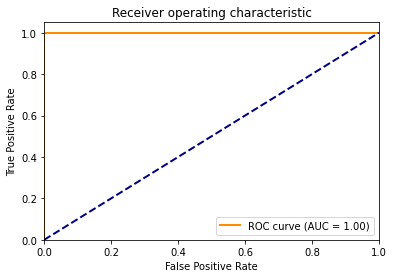

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for test set
y_pred = model.predict(X_test)

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Train Test and Validation Set on LSTM

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input
from tensorflow.keras.layers import Embedding, concatenate, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

# Load dataset
df = pd.read_csv('mqtt_merged_timeframe_multiclass_cleaned.csv')

# Drop the unnamed column
df = df.drop(df.columns[df.columns.str.contains('unnamed', case=False)], axis=1)

int_columns = df.select_dtypes(include=['int64']).columns
df[int_columns] = df[int_columns].astype('float32')

# Convert all float64 columns to float32
float_columns = df.select_dtypes(include=['float64']).columns
df[float_columns] = df[float_columns].astype('float32')

df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f', errors='coerce')
# Drop the rows that contain invalid datetime values
df.dropna(subset=['timestamp'], inplace=True)


numerical_columns = list(df.select_dtypes(include=['int32', 'float32']).columns)
print(numerical_columns)

# Identify categorical columns
categorical_columns = list(df.select_dtypes(include=['object', 'bool']).columns)
print(categorical_columns)

# Identify time-based columns
time_columns = list(df.select_dtypes(include=['datetime64']).columns)
print(time_columns)

# Preprocess data
num_features = numerical_columns
cat_features = categorical_columns
time_features = time_columns
target = 'is_attack'

# Preprocess numerical features
X_num = df[num_features].values
scaler = StandardScaler()
X_num = scaler.fit_transform(X_num)

# Preprocess categorical features
X_cat = df[cat_features].values
encoder = OneHotEncoder()
X_cat = encoder.fit_transform(X_cat).toarray()

# Preprocess time features
X_time = df[time_features].values
# convert timestamps to seconds since epoch
#X_time = np.array([pd.to_datetime(x).timestamp() for x in X_time])
X_time = df[time_features].values.astype('datetime64[s]').astype('int64')
# normalize timestamps to range [0, 1]
X_time = (X_time - X_time.min()) / (X_time.max() - X_time.min())

# Combine preprocessed features
X = np.concatenate((X_num, X_cat, X_time.reshape(-1, 1)), axis=1)
y = df[target].values

y = to_categorical(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#applying SMOTE for balancing
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Define the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=[Precision(), Recall()])
# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

['ttl', 'ip_len', 'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port', 'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn', 'tcp_flag_fin', 'mqtt_messagetype', 'mqtt_messagelength', 'mqtt_flag_uname', 'mqtt_flag_passwd', 'mqtt_flag_retain', 'mqtt_flag_qos', 'mqtt_flag_willflag', 'mqtt_flag_clean', 'mqtt_flag_reserved', 'is_attack']
['src_ip', 'dst_ip', 'protocol']
['timestamp']
Epoch 1/5
3734/3735 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9681

In [3]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test set loss and accuracy
print(f'Test set loss: {loss:.3f}')
print(f'Test set accuracy: {accuracy:.3f}')

581/581 [==============================] - 12s 18ms/step - loss: 0.0297 - precision: 1.0000 - recall: 1.0000


ValueError: too many values to unpack (expected 2)

In [4]:
# Get predicted labels for the test set
y_pred = model.predict(X_test)

# Compute other metrics such as precision, recall, F1-score, etc.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6149
         1.0       1.00      1.00      1.00     12427

    accuracy                           1.00     18576
   macro avg       1.00      1.00      1.00     18576
weighted avg       1.00      1.00      1.00     18576



In [13]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)

# Convert the predictions and labels to binary values (0 or 1)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]
binary_labels = [1 if x > 0 else 0 for x in y_test]

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)
print(cm)

[[ 6149     0]
 [    0 12427]]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for test set
y_pred = model.predict(X_test)

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [14]:
df['is_attack'].value_counts()

1.0    62670
0.0    30209
Name: is_attack, dtype: int64

In [12]:
y_pred[1]

array([0.9209969], dtype=float32)

In [10]:
my_series = pd.Series(y_pred_classes)
my_series.value_counts()

0    18576
dtype: int64

# Removing IP Addresses to check whether it is the reason for the overfit

In [7]:
y_pred = model.predict(X_test[0:3])

In [8]:
y_pred

array([[9.9999952e-01, 2.1323390e-10, 4.7935396e-07, 4.0301503e-12,
        4.0542934e-14],
       [9.9999964e-01, 2.5570751e-10, 4.0100562e-07, 3.7360275e-12,
        6.2616890e-14],
       [9.9999952e-01, 2.2589704e-10, 4.5227782e-07, 3.9249611e-12,
        4.6271821e-14]], dtype=float32)

In [3]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)

# Convert the predictions and labels to binary values (0 or 1)
binary_predictions = [1 if x > 0.5 else 0 for x in predictions]
binary_labels = [1 if x > 0 else 0 for x in y_test]

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)
print(cm)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predictions for test set
y_pred = model.predict(X_test)

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

ValueError: multilabel-indicator format is not supported